In [40]:
#Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import sklearn.model_selection as ms

import missingno as msno

import plotly
import plotly.graph_objects as go
import plotly.express as px

import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram
from scipy import stats

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [41]:
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)

#Reading the datafile
df = pd.read_csv("tripadvisor_european_restaurants.csv", low_memory=False)
#Leaving only my country
df=df.drop(df[df.country!="Poland"].index)

# Not important columns are dropped
df=df.drop(columns=['country','latitude','longitude','restaurant_link','restaurant_name','original_location','region','address','city','price_level','popularity_detailed','top_tags','original_open_hours','default_language','reviews_count_in_default_language','atmosphere','keywords'])

# average price in euro
df['minimum_range'] = df['price_range'].str.split('-').str[0].str.replace('€', '').str.replace(',', '')
df['minimum_range'] = pd.to_numeric(df['minimum_range'], errors='coerce')
df['maximum_range'] = df['price_range'].str.split('-').str[1].str.replace('€', '').str.replace(',', '')
df['maximum_range'] = pd.to_numeric(df['maximum_range'], errors='coerce')
df['average_price'] = (df['minimum_range'] + df['maximum_range']) / 2

# drop the fields used for average_price calculation
df=df.drop(columns=['minimum_range', 'maximum_range','price_range'])

#fill nan's
df=df.fillna({'value':df["value"].mean()})
df=df.fillna({'open_days_per_week':df["open_days_per_week"].mean()})
df=df.fillna({'open_hours_per_week':df["open_hours_per_week"].mean()})
df=df.fillna({'working_shifts_per_week':df["working_shifts_per_week"].mean()})
df=df.fillna({'food':df["food"].mean()})
df=df.fillna({'service':df["service"].mean()})
df=df.fillna({'excellent':0.0})
df=df.fillna({'very_good':0.0})
df=df.fillna({'average':0.0})
df=df.fillna({'poor':0.0})
df=df.fillna({'terrible':0.0})
df=df.fillna({'average_price':0.0})

df=df.fillna({'avg_rating':0.0})
df=df.fillna({'total_reviews_count':0.0})

#Check
df.head(5)

,province,claimed,awards,popularity_generic,meals,cuisines,special_diets,features,vegetarian_friendly,vegan_options,gluten_free,open_days_per_week,open_hours_per_week,working_shifts_per_week,avg_rating,total_reviews_count,excellent,very_good,average,poor,terrible,food,service,value,average_price
886009,Pomerania Province,Unclaimed,NaN,#1 of 1 places to eat in Kolczyglowy,NaN,NaN,NaN,NaN,N,N,N,6.728129,77.262177,6.773964,3.0,1.0,0.0,0.0,1.0,0.0,0.0,4.166965,4.150178,4.0769,0.0
886010,Greater Poland Province,Unclaimed,NaN,#1 of 5 places to eat in Kostrzyn,NaN,"Italian, French, Polish, European",NaN,NaN,N,N,N,6.728129,77.262177,6.773964,3.5,8.0,2.0,2.0,3.0,1.0,0.0,4.166965,4.150178,4.0769,6.5
886011,Greater Poland Province,Unclaimed,NaN,#4 of 5 places to eat in Kostrzyn,"Lunch, Dinner",NaN,NaN,NaN,N,N,N,7.000000,72.000000,7.000000,3.0,2.0,1.0,0.0,0.0,0.0,1.0,4.166965,4.150178,4.0769,0.0
886012,Greater Poland Province,Unclaimed,NaN,#2 of 5 places to eat in Kostrzyn,NaN,"Polish, European",NaN,NaN,N,N,N,6.728129,77.262177,6.773964,5.0,1.0,1.0,0.0,0.0,0.0,0.0,4.166965,4.150178,4.0769,0.0
886013,Greater Poland Province,Claimed,NaN,NaN,"Lunch, Dinner, After-hours, Drinks","Polish, Pizza, European",NaN,NaN,N,N,N,7.000000,58.000000,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.166965,4.150178,4.0769,7.0


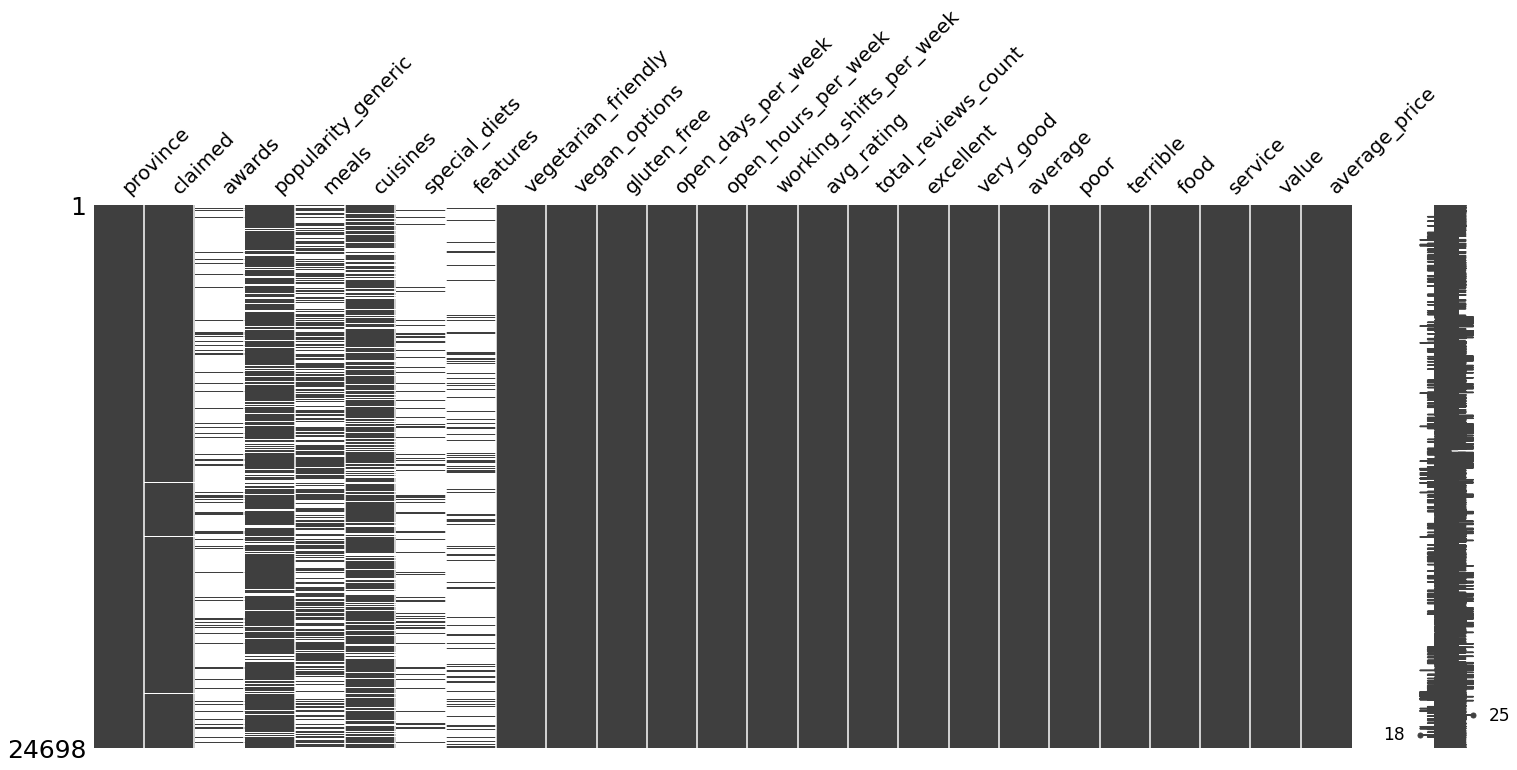

In [42]:
msno.matrix(df, fontsize=20)

In [43]:
df['province']=df[['province']].fillna(value='Unknown')

#Mapping
x=df['province'].value_counts()
item_type_mapping={}
item_list=x.index
for i in range(0,len(item_list)):
    item_type_mapping[item_list[i]]=i

df['province']=df['province'].map(lambda x:item_type_mapping[x]) 
df.head(5)

,province,claimed,awards,popularity_generic,meals,cuisines,special_diets,features,vegetarian_friendly,vegan_options,gluten_free,open_days_per_week,open_hours_per_week,working_shifts_per_week,avg_rating,total_reviews_count,excellent,very_good,average,poor,terrible,food,service,value,average_price
886009,2,Unclaimed,NaN,#1 of 1 places to eat in Kolczyglowy,NaN,NaN,NaN,NaN,N,N,N,6.728129,77.262177,6.773964,3.0,1.0,0.0,0.0,1.0,0.0,0.0,4.166965,4.150178,4.0769,0.0
886010,5,Unclaimed,NaN,#1 of 5 places to eat in Kostrzyn,NaN,"Italian, French, Polish, European",NaN,NaN,N,N,N,6.728129,77.262177,6.773964,3.5,8.0,2.0,2.0,3.0,1.0,0.0,4.166965,4.150178,4.0769,6.5
886011,5,Unclaimed,NaN,#4 of 5 places to eat in Kostrzyn,"Lunch, Dinner",NaN,NaN,NaN,N,N,N,7.000000,72.000000,7.000000,3.0,2.0,1.0,0.0,0.0,0.0,1.0,4.166965,4.150178,4.0769,0.0
886012,5,Unclaimed,NaN,#2 of 5 places to eat in Kostrzyn,NaN,"Polish, European",NaN,NaN,N,N,N,6.728129,77.262177,6.773964,5.0,1.0,1.0,0.0,0.0,0.0,0.0,4.166965,4.150178,4.0769,0.0
886013,5,Claimed,NaN,NaN,"Lunch, Dinner, After-hours, Drinks","Polish, Pizza, European",NaN,NaN,N,N,N,7.000000,58.000000,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.166965,4.150178,4.0769,7.0


In [44]:
#We can found how many other places there are in the same city
def findLargestNumber(text):
    ls = list()
    for w in text.split():
        try:
            ls.append(float(w))
        except:
            pass
    try:
        return max(ls)
    except:
        return None

df['popularity_generic']=df[['popularity_generic']].fillna(value='Unknown')
df.popularity_generic = [findLargestNumber(item) for item in df.popularity_generic]
df['popularity_generic']=df[['popularity_generic']].fillna(value=1)
df=df.rename( columns={'popularity_generic' : 'one_of_x_in_city'})
df.head(5)

,province,claimed,awards,one_of_x_in_city,meals,cuisines,special_diets,features,vegetarian_friendly,vegan_options,gluten_free,open_days_per_week,open_hours_per_week,working_shifts_per_week,avg_rating,total_reviews_count,excellent,very_good,average,poor,terrible,food,service,value,average_price
886009,2,Unclaimed,NaN,1.0,NaN,NaN,NaN,NaN,N,N,N,6.728129,77.262177,6.773964,3.0,1.0,0.0,0.0,1.0,0.0,0.0,4.166965,4.150178,4.0769,0.0
886010,5,Unclaimed,NaN,5.0,NaN,"Italian, French, Polish, European",NaN,NaN,N,N,N,6.728129,77.262177,6.773964,3.5,8.0,2.0,2.0,3.0,1.0,0.0,4.166965,4.150178,4.0769,6.5
886011,5,Unclaimed,NaN,5.0,"Lunch, Dinner",NaN,NaN,NaN,N,N,N,7.000000,72.000000,7.000000,3.0,2.0,1.0,0.0,0.0,0.0,1.0,4.166965,4.150178,4.0769,0.0
886012,5,Unclaimed,NaN,5.0,NaN,"Polish, European",NaN,NaN,N,N,N,6.728129,77.262177,6.773964,5.0,1.0,1.0,0.0,0.0,0.0,0.0,4.166965,4.150178,4.0769,0.0
886013,5,Claimed,NaN,1.0,"Lunch, Dinner, After-hours, Drinks","Polish, Pizza, European",NaN,NaN,N,N,N,7.000000,58.000000,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.166965,4.150178,4.0769,7.0


In [45]:
df['meals']=df[['meals']].fillna(value='')
df.meals=[item.count(',')+1 if item!='' else 0 for item in df.meals]

df['awards']=df[['awards']].fillna(value='')
df.awards=[item.count(',')+1 if item!='' else 0 for item in df.awards]
 
df['features']=df[['features']].fillna(value='')
df.features=[item.count(',')+1 if item!='' else 0 for item in df.features]
    
df['cuisines']=df[['cuisines']].fillna(value='')
df.cuisines=[item.count(',')+1 if item!='' else 0 for item in df.cuisines]
 
vege = {'N': 0,'Y': 1}
claimed = {'Unclaimed': 0,'Claimed': 1}

df.vegetarian_friendly = [vege[item] for item in df.vegetarian_friendly]
df.vegan_options = [vege[item] for item in df.vegan_options]
df.gluten_free = [vege[item] for item in df.gluten_free]

df['claimed']=df[['claimed']].fillna(value='Unclaimed')
df.claimed=[claimed[item] for item in df.claimed]

df['special_diets']=df[['special_diets']].fillna(value='Unknown')
df.special_diets = [item.count("Unknown") for item in df.special_diets]

specialDiet = {0: 1,1: 0}
df.special_diets = [specialDiet[item] for item in df.special_diets]


df.head(15)

,province,claimed,awards,one_of_x_in_city,meals,cuisines,special_diets,features,vegetarian_friendly,vegan_options,gluten_free,open_days_per_week,open_hours_per_week,working_shifts_per_week,avg_rating,total_reviews_count,excellent,very_good,average,poor,terrible,food,service,value,average_price
886009,2,0,0,1.0,0,0,0,0,0,0,0,6.728129,77.262177,6.773964,3.0,1.0,0.0,0.0,1.0,0.0,0.0,4.166965,4.150178,4.0769,0.0
886010,5,0,0,5.0,0,4,0,0,0,0,0,6.728129,77.262177,6.773964,3.5,8.0,2.0,2.0,3.0,1.0,0.0,4.166965,4.150178,4.0769,6.5
886011,5,0,0,5.0,2,0,0,0,0,0,0,7.000000,72.000000,7.000000,3.0,2.0,1.0,0.0,0.0,0.0,1.0,4.166965,4.150178,4.0769,0.0
886012,5,0,0,5.0,0,2,0,0,0,0,0,6.728129,77.262177,6.773964,5.0,1.0,1.0,0.0,0.0,0.0,0.0,4.166965,4.150178,4.0769,0.0
886013,5,1,0,1.0,4,3,0,0,0,0,0,7.000000,58.000000,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.166965,4.150178,4.0769,7.0
886014,5,0,0,5.0,0,1,0,0,0,0,0,6.728129,77.262177,6.773964,5.0,1.0,1.0,0.0,0.0,0.0,0.0,4.166965,4.150178,4.0769,0.0
886015,13,0,0,1.0,0,2,0,0,0,0,0,6.728129,77.262177,6.773964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.166965,4.150178,4.0769,6.0
886016,0,0,0,13.0,0,1,0,0,0,0,0,6.728129,77.262177,6.773964,3.0,2.0,0.0,0.0,2.0,0.0,0.0,4.166965,4.150178,4.0769,0.0
886017,0,0,0,13.0,2,0,0,0,0,0,0,6.000000,42.000000,6.000000,3.5,3.0,0.0,2.0,1.0,0.0,0.0,4.166965,4.150178,4.0769,0.0
886018,0,0,0,13.0,0,4,0,0,0,0,0,6.728129,77.262177,6.773964,4.0,14.0,0.0,2.0,0.0,0.0,0.0,4.000000,4.000000,4.0000,4.0


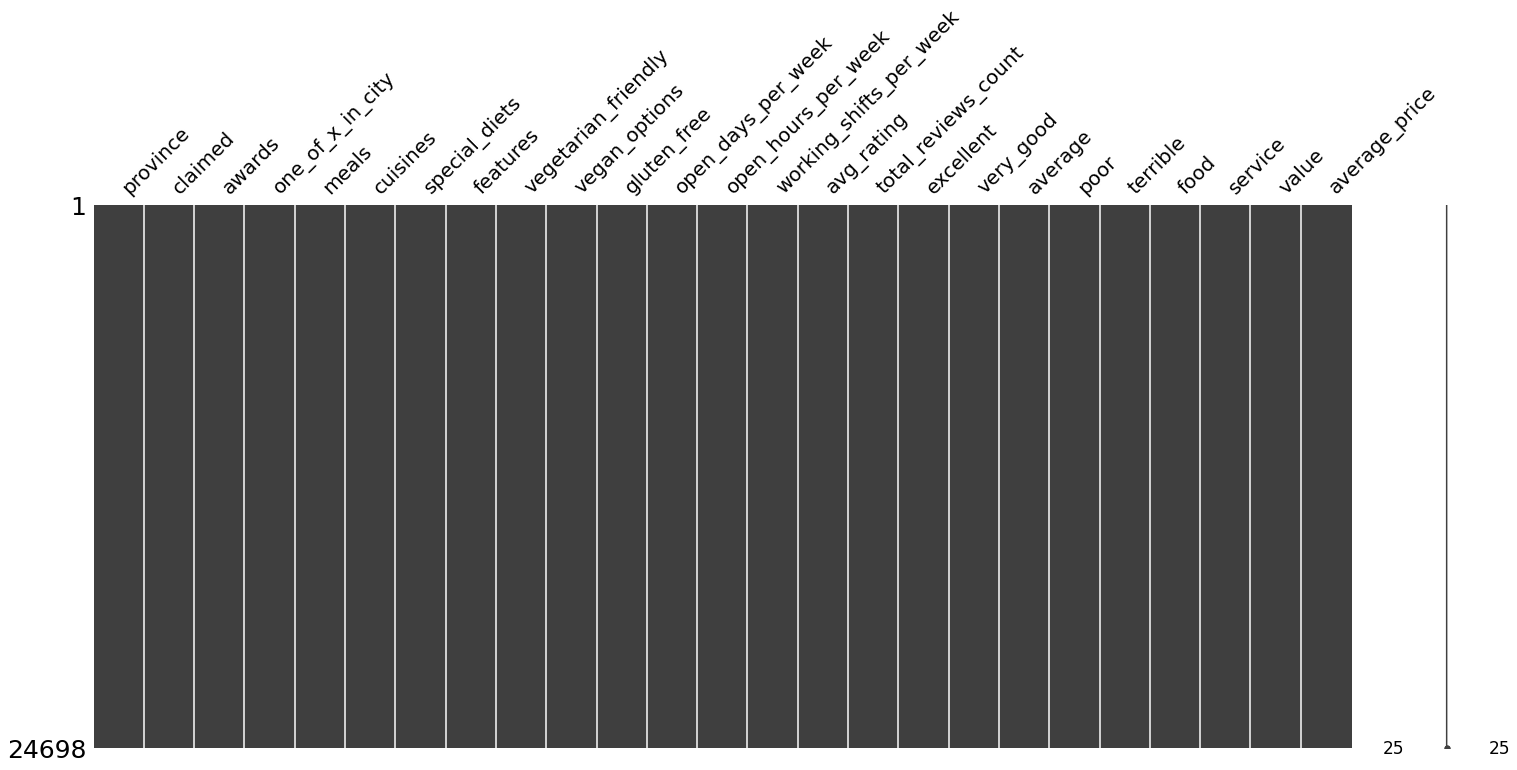

In [46]:
msno.matrix(df, fontsize=20)

In [47]:
#2
df.describe()

,province,claimed,awards,one_of_x_in_city,meals,cuisines,special_diets,features,vegetarian_friendly,vegan_options,gluten_free,open_days_per_week,open_hours_per_week,working_shifts_per_week,avg_rating,total_reviews_count,excellent,very_good,average,poor,terrible,food,service,value,average_price
count,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.00000,24698.000000
mean,4.180784,0.375658,0.487327,741.282331,1.485181,1.932262,0.142967,0.702810,0.139404,0.058831,0.031582,6.728129,77.262177,6.773964,3.454247,49.478622,8.498502,3.687424,1.318852,0.628067,0.757227,4.166965,4.150178,4.07690,3.103895
std,3.906517,0.484302,1.422813,1176.562948,1.675321,1.628710,0.350046,2.418938,0.346375,0.235312,0.174887,0.534719,21.681179,0.656977,1.643493,164.894220,45.176975,17.116831,6.099053,2.742321,3.234466,0.352619,0.350820,0.35804,12.092364
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.500000,1.00000,0.000000
25%,1.000000,0.000000,0.000000,6.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.728129,71.000000,6.773964,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.166965,4.150178,4.07690,0.000000
50%,3.000000,0.000000,0.000000,74.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.728129,77.262177,6.773964,4.000000,9.000000,1.000000,1.000000,0.000000,0.000000,0.000000,4.166965,4.150178,4.07690,0.000000
75%,6.000000,1.000000,0.000000,1056.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,77.262177,7.000000,4.500000,34.000000,4.000000,2.000000,1.000000,0.000000,0.000000,4.166965,4.150178,4.07690,4.000000
max,16.000000,1.000000,11.000000,3547.000000,6.000000,14.000000,1.000000,24.000000,1.000000,1.000000,1.000000,7.000000,167.883333,14.000000,5.000000,6698.000000,3120.000000,787.000000,435.000000,164.000000,132.000000,5.000000,5.000000,5.00000,1253.500000


In [48]:
df.mode()

,province,claimed,awards,one_of_x_in_city,meals,cuisines,special_diets,features,vegetarian_friendly,vegan_options,gluten_free,open_days_per_week,open_hours_per_week,working_shifts_per_week,avg_rating,total_reviews_count,excellent,very_good,average,poor,terrible,food,service,value,average_price
0,0,0,0,1.0,0,2,0,0,0,0,0,6.728129,77.262177,6.773964,4.5,0.0,0.0,0.0,0.0,0.0,0.0,4.166965,4.150178,4.0769,0.0


In [49]:
df.median()

province                    3.000000
claimed                     0.000000
awards                      0.000000
one_of_x_in_city           74.000000
meals                       1.000000
cuisines                    2.000000
special_diets               0.000000
features                    0.000000
vegetarian_friendly         0.000000
vegan_options               0.000000
gluten_free                 0.000000
open_days_per_week          6.728129
open_hours_per_week        77.262177
working_shifts_per_week     6.773964
avg_rating                  4.000000
total_reviews_count         9.000000
excellent                   1.000000
very_good                   1.000000
average                     0.000000
poor                        0.000000
terrible                    0.000000
food                        4.166965
service                     4.150178
value                       4.076900
average_price               0.000000
dtype: float64

In [50]:
#3 Detecting outliers
def IQR_outliner_detection(var):
    q_1,q_3=np.percentile(var,[25,75])
    IQR=q_3-q_1
    lower_bound=q_1-(IQR*1.5)
    upper_bound=q_3+(IQR*1.5)
    return np.where((var>upper_bound) | (var<lower_bound))

pom=IQR_outliner_detection(df.province)[0]
OutliersDF = pd.DataFrame(pom, columns=['province'])

pom=IQR_outliner_detection(df.claimed)[0]
OutliersDF2=pd.DataFrame(pom, columns=['claimed'])

pom=IQR_outliner_detection(df.awards)[0]
OutliersDF3=pd.DataFrame(pom, columns=['awards'])

pom=IQR_outliner_detection(df.one_of_x_in_city)[0]
OutliersDF4=pd.DataFrame(pom, columns=['one_of_x_in_city'])

pom=IQR_outliner_detection(df.meals)[0]
OutliersDF5=pd.DataFrame(pom, columns=['meals'])

pom=IQR_outliner_detection(df.cuisines)[0]
OutliersDF6=pd.DataFrame(pom, columns=['cuisines'])

pom=IQR_outliner_detection(df.special_diets)[0]
OutliersDF7=pd.DataFrame(pom, columns=['special_diets'])

pom=IQR_outliner_detection(df.vegetarian_friendly)[0]
OutliersDF8=pd.DataFrame(pom, columns=['vegetarian_friendly'])

pom=IQR_outliner_detection(df.open_days_per_week)[0]
OutliersDF9=pd.DataFrame(pom, columns=['open_days_per_week'])

pom=IQR_outliner_detection(df.open_hours_per_week)[0]
OutliersDF10=pd.DataFrame(pom, columns=['open_hours_per_week'])

pom=IQR_outliner_detection(df.working_shifts_per_week)[0]
OutliersDF11=pd.DataFrame(pom, columns=['working_shifts_per_week'])

pom=IQR_outliner_detection(df.avg_rating)[0]
OutliersDF12=pd.DataFrame(pom, columns=['avg_rating'])

pom=IQR_outliner_detection(df.total_reviews_count)[0]
OutliersDF13=pd.DataFrame(pom, columns=['total_reviews_count'])

pom=IQR_outliner_detection(df.excellent)[0]
OutliersDF14=pd.DataFrame(pom, columns=['excellent'])

pom=IQR_outliner_detection(df.very_good)[0]
OutliersDF15=pd.DataFrame(pom, columns=['very_good'])

pom=IQR_outliner_detection(df.average)[0]
OutliersDF16=pd.DataFrame(pom, columns=['average'])

pom=IQR_outliner_detection(df.poor)[0]
OutliersDF17=pd.DataFrame(pom, columns=['poor'])

pom=IQR_outliner_detection(df.terrible)[0]
OutliersDF18=pd.DataFrame(pom, columns=['terrible'])

pom=IQR_outliner_detection(df.food)[0]
OutliersDF19=pd.DataFrame(pom, columns=['food'])

pom=IQR_outliner_detection(df.service)[0]
OutliersDF20=pd.DataFrame(pom, columns=['service'])

pom=IQR_outliner_detection(df.value)[0]
OutliersDF21=pd.DataFrame(pom, columns=['value'])

pom=IQR_outliner_detection(df.average_price)[0]
OutliersDF22=pd.DataFrame(pom, columns=['average_price'])

pom=IQR_outliner_detection(df.awards)[0]
OutliersDF23=pd.DataFrame(pom, columns=['features'])

pom=IQR_outliner_detection(df.awards)[0]
OutliersDF24=pd.DataFrame(pom, columns=['vegan_options'])

pom=IQR_outliner_detection(df.awards)[0]
OutliersDF25=pd.DataFrame(pom, columns=['gluten_free'])


result=pd.concat([OutliersDF,OutliersDF2,OutliersDF3,OutliersDF4,
                 OutliersDF5,OutliersDF6,OutliersDF7,OutliersDF8,
                 OutliersDF9,OutliersDF10,OutliersDF11,OutliersDF12,
                 OutliersDF13,OutliersDF14,OutliersDF15,OutliersDF16,
                 OutliersDF17,OutliersDF18,OutliersDF19,OutliersDF20,
                 OutliersDF21,OutliersDF22,OutliersDF23,OutliersDF24,
                 OutliersDF25],axis=1)
result

,province,claimed,awards,one_of_x_in_city,meals,cuisines,special_diets,vegetarian_friendly,open_days_per_week,open_hours_per_week,working_shifts_per_week,avg_rating,total_reviews_count,excellent,very_good,average,poor,terrible,food,service,value,average_price,features,vegan_options,gluten_free
0,219.0,NaN,21.0,18549.0,NaN,68.0,17.0,17.0,8.0,4.0,8.0,4.0,17.0,15.0,17.0,1.0,1.0,2.0,9.0,9,9.0,61.0,21.0,21.0,21.0
1,220.0,NaN,33.0,18550.0,NaN,245.0,26.0,26.0,14.0,8.0,14.0,6.0,21.0,46.0,46.0,37.0,11.0,10.0,10.0,10,10.0,71.0,33.0,33.0,33.0
2,221.0,NaN,34.0,18551.0,NaN,441.0,33.0,33.0,15.0,12.0,15.0,39.0,31.0,49.0,49.0,46.0,25.0,11.0,15.0,15,15.0,93.0,34.0,34.0,34.0
3,222.0,NaN,46.0,18552.0,NaN,538.0,46.0,46.0,22.0,14.0,22.0,74.0,33.0,67.0,63.0,49.0,27.0,17.0,17.0,17,17.0,98.0,46.0,46.0,46.0
4,223.0,NaN,48.0,18553.0,NaN,541.0,50.0,50.0,26.0,15.0,26.0,82.0,46.0,78.0,67.0,68.0,33.0,20.0,19.0,19,19.0,111.0,48.0,48.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24678,NaN,NaN,NaN,NaN,NaN
10124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24690,NaN,NaN,NaN,NaN,NaN
10125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24692,NaN,NaN,NaN,NaN,NaN
10126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24694,NaN,NaN,NaN,NaN,NaN


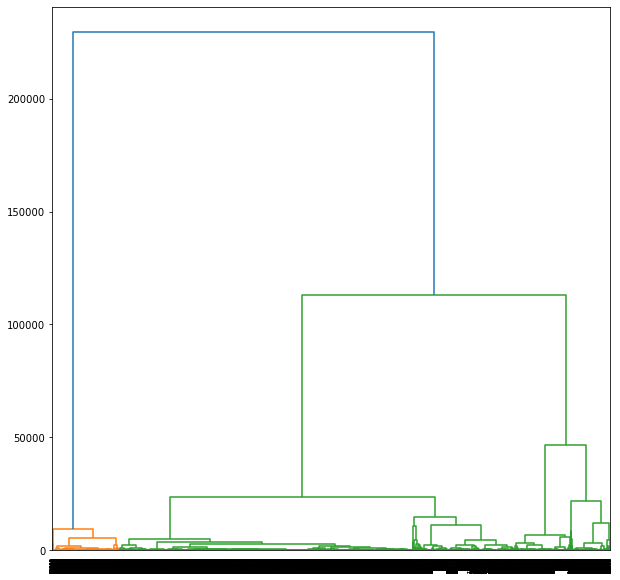

In [51]:
#4
dend = shc.dendrogram(shc.linkage(df, method='ward'))

In [37]:
#5
x=df.drop(columns=['avg_rating'])
pca = PCA(n_components=2)
princComp=pca.fit_transform(x)
print(princComp)

[[-741.09281467  -34.87142171]
 [-736.94688552  -27.42744249]
 [-737.06968257  -33.75283637]
 ...
 [-740.49146669   -3.47618068]
 [-740.01756128  -31.2900529 ]
 [-741.19451376  -36.05892506]]


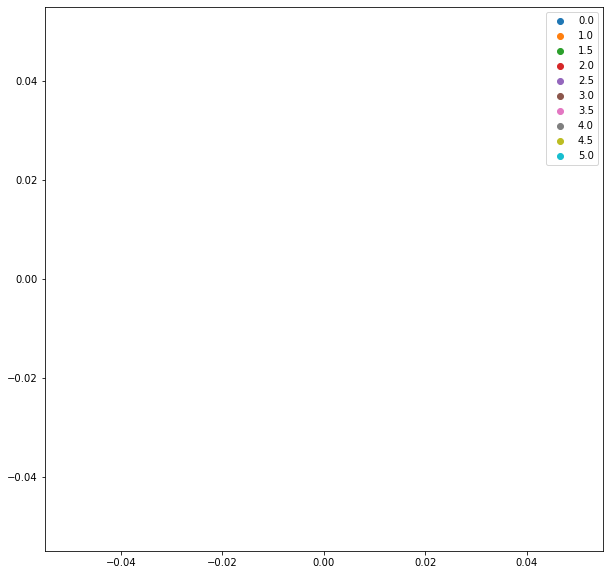

In [39]:
tempDf = pd.DataFrame(princComp,columns = ['0','1'])

finalDF = pd.concat([tempDf,df[['avg_rating']]],axis =1)

groups = finalDF.groupby("avg_rating")

plt.rcParams["figure.figsize"] = (10,10)#Plot size

for name, group in groups:
    plt.plot(group["0"],group["1"],marker="o",linestyle="",label=name)

plt.legend()

In [63]:
#6
df=df.rename( columns={'avg_rating' : 'target'})
abs(df.corr().sort_values(by='target'))

,province,claimed,awards,one_of_x_in_city,meals,cuisines,special_diets,features,vegetarian_friendly,vegan_options,gluten_free,open_days_per_week,open_hours_per_week,working_shifts_per_week,target,total_reviews_count,excellent,very_good,average,poor,terrible,food,service,value,average_price
open_hours_per_week,0.010658,0.184553,0.042531,0.050372,0.076060,0.159346,0.049854,0.034003,0.048341,0.041116,0.031271,0.437626,1.000000,0.362674,0.293168,0.023198,0.022403,0.003821,0.004239,0.008450,0.026732,0.089614,0.092458,0.081872,0.064780
open_days_per_week,0.003694,0.029084,0.043328,0.014658,0.029163,0.024484,0.035848,0.019323,0.037833,0.026227,0.019724,1.000000,0.437626,0.823089,0.044882,0.044737,0.025693,0.043914,0.043069,0.038846,0.040703,0.051113,0.050544,0.049472,0.022335
province,1.000000,0.064897,0.073066,0.468018,0.028059,0.045079,0.081438,0.028748,0.077636,0.067731,0.066853,0.003694,0.010658,0.011531,0.030374,0.083338,0.088723,0.097637,0.085851,0.088028,0.082677,0.021788,0.006245,0.017683,0.032416
working_shifts_per_week,0.011531,0.003742,0.039719,0.016978,0.030175,0.004045,0.036403,0.015637,0.038715,0.030310,0.021818,0.823089,0.362674,1.000000,0.022682,0.035066,0.020230,0.033282,0.032638,0.029055,0.028105,0.033208,0.030830,0.033363,0.006165
terrible,0.082677,0.101984,0.254609,0.127368,0.052210,0.112078,0.214118,0.153363,0.206472,0.170598,0.229371,0.040703,0.026732,0.028105,0.029312,0.588678,0.505143,0.676887,0.761486,0.829718,1.000000,0.146331,0.167181,0.153227,0.035744
meals,0.028059,0.457401,0.077551,0.052584,1.000000,0.172087,0.004683,0.217688,0.007293,0.007501,0.026058,0.029163,0.076060,0.030175,0.042401,0.085020,0.053786,0.070282,0.060092,0.061639,0.052210,0.055959,0.050241,0.049595,0.107038
average_price,0.032416,0.229531,0.066468,0.055861,0.107038,0.154164,0.073926,0.002923,0.068770,0.060442,0.075886,0.022335,0.064780,0.006165,0.053296,0.067040,0.060148,0.047324,0.045019,0.045936,0.035744,0.048824,0.057340,0.035200,1.000000
poor,0.088028,0.131700,0.355454,0.142536,0.061639,0.131357,0.271950,0.172315,0.263207,0.239532,0.325897,0.038846,0.008450,0.029055,0.058110,0.733760,0.656491,0.843280,0.910550,1.000000,0.829718,0.073984,0.091589,0.086773,0.045936
average,0.085851,0.133293,0.396253,0.144938,0.060092,0.128457,0.276863,0.174408,0.267647,0.248604,0.338243,0.043069,0.004239,0.032638,0.070666,0.802207,0.757605,0.927988,1.000000,0.910550,0.761486,0.028926,0.046285,0.033799,0.045019
very_good,0.097637,0.149836,0.499945,0.162215,0.070282,0.143877,0.314345,0.192381,0.305312,0.295434,0.392758,0.043914,0.003821,0.033282,0.090467,0.887648,0.878724,1.000000,0.927988,0.843280,0.676887,0.028774,0.002358,0.025146,0.047324


In [64]:
#7
df=df.drop(columns=['excellent','very_good','average','poor','terrible'])
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('target')
test_labels = test_features.pop('target')

normalizer = preprocessing.Normalization()

normalizer.adapt(np.array(train_features))

In [65]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation="selu"),
        layers.Dense(64, activation="selu"),
        layers.Dense(64, activation="selu"),
        layers.Dense(64, activation="selu"),
        layers.Dense(1)
    ])
    
    model.compile(
        #loss='mean_absolute_percentage_error',
        loss='mean_absolute_error',
        optimizer = tf.keras.optimizers.Adam(0.002))
    return model

In [66]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 19)                39        
_________________________________________________________________
dense (Dense)                (None, 64)                1280      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 13,864
Trainable params: 13,825
Non-trainable params: 39
___________________________________________________

In [67]:
history = dnn_model.fit(
    train_features, train_labels,
    validation_split = 0.2,
    verbose=1, epochs = 100)

Epoch 1/100
494/494 [==============================] - 1s 1ms/step - loss: 1.2762 - val_loss: 0.9153
Epoch 2/100
494/494 [==============================] - 0s 845us/step - loss: 0.9158 - val_loss: 0.8824
Epoch 3/100
494/494 [==============================] - 0s 858us/step - loss: 0.8767 - val_loss: 0.8422
Epoch 4/100
494/494 [==============================] - 0s 845us/step - loss: 0.8179 - val_loss: 0.8661
Epoch 5/100
494/494 [==============================] - 0s 845us/step - loss: 0.7866 - val_loss: 0.7716
Epoch 6/100
494/494 [==============================] - 0s 877us/step - loss: 0.7360 - val_loss: 0.7561
Epoch 7/100
494/494 [==============================] - 0s 890us/step - loss: 0.7083 - val_loss: 0.6968
Epoch 8/100
494/494 [==============================] - 0s 845us/step - loss: 0.6566 - val_loss: 0.7221
Epoch 9/100
494/494 [==============================] - 0s 813us/step - loss: 0.6462 - val_loss: 0.6840
Epoch 10/100
494/494 [==============================] - 0s 813us/step - los

Epoch 80/100
494/494 [==============================] - 0s 985us/step - loss: 0.5383 - val_loss: 0.5330
Epoch 81/100
494/494 [==============================] - 0s 941us/step - loss: 0.4833 - val_loss: 0.5546
Epoch 82/100
494/494 [==============================] - 0s 871us/step - loss: 0.5193 - val_loss: 0.5151
Epoch 83/100
494/494 [==============================] - 0s 862us/step - loss: 0.4893 - val_loss: 0.5425
Epoch 84/100
494/494 [==============================] - 0s 921us/step - loss: 0.4774 - val_loss: 0.4614
Epoch 85/100
494/494 [==============================] - 0s 909us/step - loss: 0.5075 - val_loss: 0.5038
Epoch 86/100
494/494 [==============================] - 0s 877us/step - loss: 0.4810 - val_loss: 0.6636
Epoch 87/100
494/494 [==============================] - 0s 890us/step - loss: 0.5497 - val_loss: 0.5861
Epoch 88/100
494/494 [==============================] - 0s 814us/step - loss: 0.5167 - val_loss: 0.4747
Epoch 89/100
494/494 [==============================] - 0s 985us

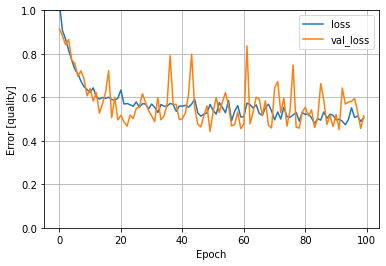

In [68]:
def plot_loss(history):
    plt.plot(history.history['loss'], label = 'loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.ylim([0, 1.0])
    plt.xlabel('Epoch')
    plt.ylabel('Error [quality]')
    plt.legend()
    plt.grid(True)
    
plot_loss(history)

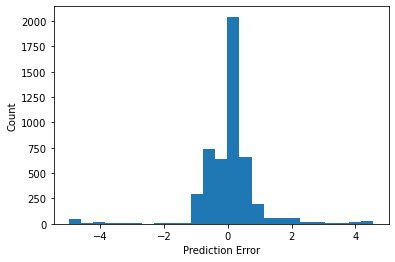

In [69]:
test_predictions = dnn_model.predict(test_features).flatten()

error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')